# **1. Import libraries**

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# random
import random

# OrderedDict
from collections import OrderedDict

# warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **2. Load data and visualization**

In [2]:
IMAGE_PATH = Path("/kaggle/input/potato-diseases-datasets")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg")) + list(IMAGE_PATH.glob("*/*.jpeg")) + list(IMAGE_PATH.glob("*/*.png"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 451


In [3]:
CLASSES = os.listdir(IMAGE_PATH)
CLASSES = sorted(CLASSES)

print("==" * 20)
print(" " * 10, f"Total Classes = {len(CLASSES)}")
print("==" * 20)

for label in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpeg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.png"))
    print(f'* {label}: {len(total_images_class)} images')

           Total Classes = 7
* Black Scurf: 58 images
* Blackleg: 60 images
* Common Scab: 62 images
* Dry Rot: 60 images
* Healthy Potatoes: 80 images
* Miscellaneous: 74 images
* Pink Rot: 57 images


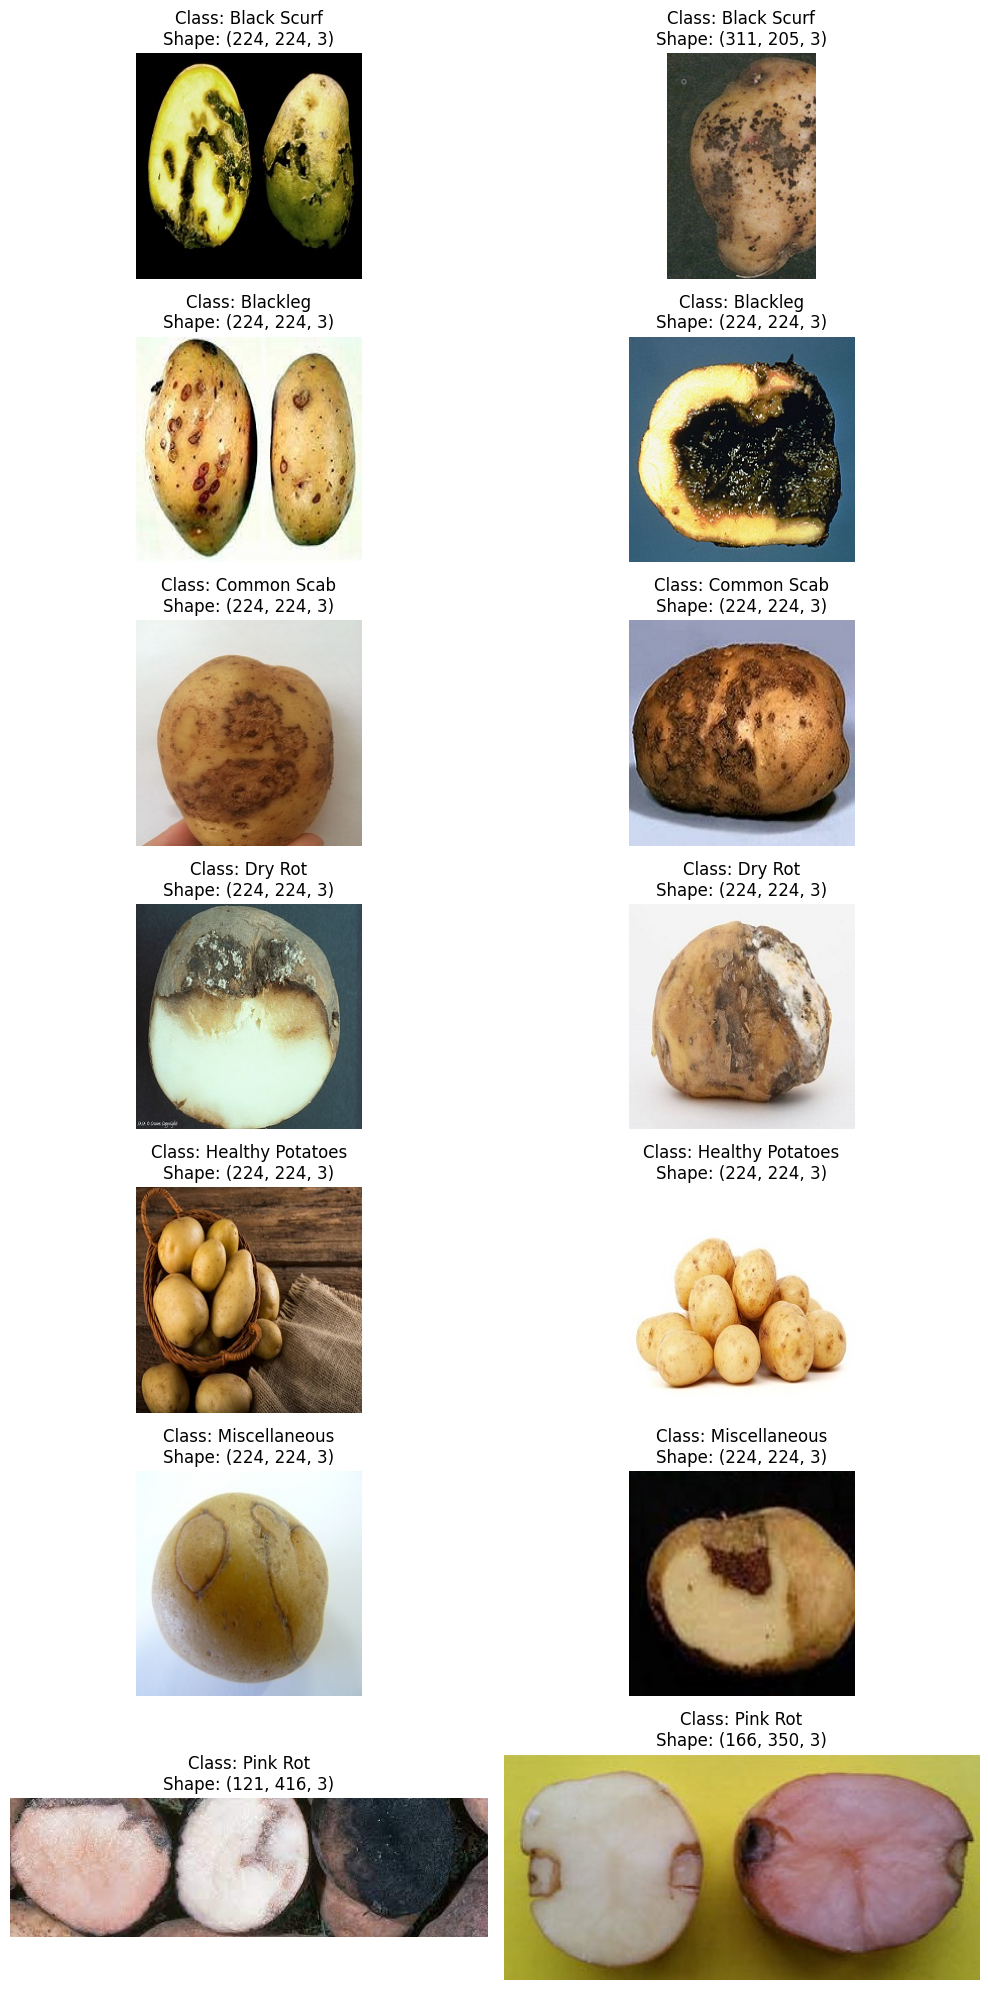

In [4]:
NUM_IMAGES = 2

fig, ax = plt.subplots(nrows = len(CLASSES), 
                       ncols = NUM_IMAGES, 
                       figsize = (10,20))

p = 0

for label in CLASSES:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.jpeg")) + list(Path(os.path.join(IMAGE_PATH, label)).glob("*.png"))
    total_images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(total_images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis('off')
        ax[p,i].set_title(f'Class: {label}\nShape: {img_rgb.shape}')
        
    p += 1
    
fig.tight_layout()
fig.show()

# **3. Preprocessing**

We create a **dataframe** where we store the **paths of the images** and their **respective label**.

In [5]:
image_paths = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    image_paths[i] = img_path
    labels[i] = img_path.parent.stem
    
data = pd.DataFrame({'Image':image_paths, 'Label':labels})
data.head()

,Image,Label
0,/kaggle/input/potato-diseases-datasets/Black S...,Black Scurf
1,/kaggle/input/potato-diseases-datasets/Black S...,Black Scurf
2,/kaggle/input/potato-diseases-datasets/Black S...,Black Scurf
3,/kaggle/input/potato-diseases-datasets/Black S...,Black Scurf
4,/kaggle/input/potato-diseases-datasets/Black S...,Black Scurf


In [35]:
# We are going to perform bootstrap sampling to increase the number of images.
SEED = 42

num_samples = 10
new_output = [None] * num_samples

for i,sample in enumerate(range(num_samples)):
    new_output[i] = data.sample(n = len(data), replace = True, random_state = SEED)
    
data_new = pd.concat((new_output), ignore_index = True)
data_new.head()

,Image,Label
0,/kaggle/input/potato-diseases-datasets/Blackle...,Blackleg
1,/kaggle/input/potato-diseases-datasets/Healthy...,Healthy Potatoes
2,/kaggle/input/potato-diseases-datasets/Miscell...,Miscellaneous
3,/kaggle/input/potato-diseases-datasets/Dry Rot...,Dry Rot
4,/kaggle/input/potato-diseases-datasets/Blackle...,Blackleg


In [36]:
data_new['Label'].value_counts()

Label
Healthy Potatoes    770
Common Scab         710
Miscellaneous       700
Dry Rot             640
Black Scurf         600
Pink Rot            590
Blackleg            500
Name: count, dtype: int64

**Now we take `70%` of our new dataframe for `training`, `15% validation` and `15% for testing`.**

In [38]:
data_train, data_rest = train_test_split(data_new, 
                                         test_size = 0.3, 
                                         random_state = SEED, 
                                         stratify = data_new['Label'])

data_val, data_test = train_test_split(data_rest, 
                                       test_size = 0.5, 
                                       random_state = SEED, 
                                       stratify = data_rest['Label'])

In [7]:
# Let's define a dictionary to map the labels and convert them to numbers.
label2id = dict(zip(CLASSES, range(len(CLASSES))))
label2id

{'Black Scurf': 0,
 'Blackleg': 1,
 'Common Scab': 2,
 'Dry Rot': 3,
 'Healthy Potatoes': 4,
 'Miscellaneous': 5,
 'Pink Rot': 6}

We create our **Dataset** and **DataLoader**.

- **Dataset**

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame, 
                 transforms, 
                 label2id:dict):
        
        self.data = data
        self.transforms = transforms
        self.label2id = label2id
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_new = self.data.copy()
        data_new['Label'] = data_new['Label'].map(self.label2id)
        
        # Image
        image_path = data_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        
        # Target
        target = data_new.iloc[idx, 1]
        
        return image, target

In [9]:
# We are going to use the transformations that are applied to the images for pre-training.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [39]:
train_dataset = CustomImageDataset(data_train, auto_transforms, label2id)

val_dataset = CustomImageDataset(data_val, auto_transforms, label2id)

- **DataLoader**

In [40]:
BATCH_SIZE = 32

NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS)

In [41]:
# We visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# **4. Model**

In [13]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
DEVICE

'cuda'

In [14]:
# Define model
model = resnet50(weights = weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s] 


In [15]:
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [12, 3, 224, 224] [12, 1000]        --                True
├─Conv2d (conv1)                         [12, 3, 224, 224] [12, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [12, 64, 112, 112] [12, 64, 112, 112] 128               True
├─ReLU (relu)                            [12, 64, 112, 112] [12, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [12, 64, 112, 112] [12, 64, 56, 56]  --                --
├─Sequential (layer1)                    [12, 64, 56, 56]  [12, 256, 56, 56] --                True
│    └─Bottleneck (0)                    [12, 64, 56, 56]  [12, 256, 56, 56] --                True
│    │    └─Conv2d (conv1)               [12, 64, 56, 56]  [12, 64, 56, 56]  4,096             True
│    │    └─BatchNorm2d (bn1)            [12, 64, 56, 56]  [12, 64, 56, 56]  128             

**Freeze the extractor layers**.

In [16]:
for param in model.conv1.parameters():
    param.requires_grad = False
    
for param in model.bn1.parameters():
    param.requires_grad = False
    
for param in model.layer1.parameters():
    param.requires_grad = False
    
for param in model.layer2.parameters():
    param.requires_grad = False
    
for param in model.layer3.parameters():
    param.requires_grad = False
    
for param in model.layer4.parameters():
    param.requires_grad = False

In [17]:
# We see if the extractor layers were frozen.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [12, 3, 224, 224] [12, 1000]        --                Partial
├─Conv2d (conv1)                         [12, 3, 224, 224] [12, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [12, 64, 112, 112] [12, 64, 112, 112] (128)             False
├─ReLU (relu)                            [12, 64, 112, 112] [12, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [12, 64, 112, 112] [12, 64, 56, 56]  --                --
├─Sequential (layer1)                    [12, 64, 56, 56]  [12, 256, 56, 56] --                False
│    └─Bottleneck (0)                    [12, 64, 56, 56]  [12, 256, 56, 56] --                False
│    │    └─Conv2d (conv1)               [12, 64, 56, 56]  [12, 64, 56, 56]  (4,096)           False
│    │    └─BatchNorm2d (bn1)            [12, 64, 56, 56]  [12, 64, 56, 56]  (128)   

Great, the extractor layers were frozen, now we need to modify the **output** which has to be equal to the **number of classes**.

In [18]:
output_shape = len(CLASSES)

model.fc = nn.Linear(in_features = 2048, out_features = output_shape)

In [19]:
# We last view our model to check if the last layer was modified.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width = 17, 
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [12, 3, 224, 224] [12, 7]           --                Partial
├─Conv2d (conv1)                         [12, 3, 224, 224] [12, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [12, 64, 112, 112] [12, 64, 112, 112] (128)             False
├─ReLU (relu)                            [12, 64, 112, 112] [12, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [12, 64, 112, 112] [12, 64, 56, 56]  --                --
├─Sequential (layer1)                    [12, 64, 56, 56]  [12, 256, 56, 56] --                False
│    └─Bottleneck (0)                    [12, 64, 56, 56]  [12, 256, 56, 56] --                False
│    │    └─Conv2d (conv1)               [12, 64, 56, 56]  [12, 64, 56, 56]  (4,096)           False
│    │    └─BatchNorm2d (bn1)            [12, 64, 56, 56]  [12, 64, 56, 56]  (128)   

We define the **loss function** and the **optimizer**.

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

We define some functions to execute our training:
- **EarlyStopping**
- **train_step**
- **val_step**
- **predictions**

In [44]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [45]:
early_stopping = EarlyStopping(patience = 20, delta = 0.)

In [46]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0
    train_accuracy = 0
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)
        
        optimizer.zero_grad()
        
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = y_pred_logit.softmax(dim = 1)
        y_pred_class = y_pred_prob.argmax(dim = 1)
        
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [47]:
def val_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
             loss_fn:torch.nn.Module):
    
    model.eval()
    
    val_loss = 0
    val_accuracy = 0
    
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)

            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            val_loss += loss.item()

            y_pred_prob = y_pred_logit.softmax(dim = 1)
            y_pred_class = y_pred_prob.argmax(dim = 1)

            val_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
        
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    
    return val_loss, val_accuracy

In [48]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        val_loss, val_accuracy = val_step(model = model, 
                                          dataloader = val_dataloader, 
                                          loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train Accuracy: {train_accuracy:.4f} | ', 
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val Accuracy: {val_accuracy:.4f}')
        
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)
        
    return results
    

In [49]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0728 |  Train Accuracy: 0.9766 |  Val Loss: 0.0032 |  Val Accuracy: 1.0000
Epoch: 2 |  Train Loss: 0.0057 |  Train Accuracy: 0.9994 |  Val Loss: 0.0010 |  Val Accuracy: 1.0000
Epoch: 3 |  Train Loss: 0.0052 |  Train Accuracy: 1.0000 |  Val Loss: 0.0009 |  Val Accuracy: 1.0000
Epoch: 4 |  Train Loss: 0.0046 |  Train Accuracy: 1.0000 |  Val Loss: 0.0007 |  Val Accuracy: 1.0000
Epoch: 5 |  Train Loss: 0.0032 |  Train Accuracy: 1.0000 |  Val Loss: 0.0010 |  Val Accuracy: 1.0000
Epoch: 6 |  Train Loss: 0.0039 |  Train Accuracy: 1.0000 |  Val Loss: 0.0009 |  Val Accuracy: 1.0000
Epoch: 7 |  Train Loss: 0.0070 |  Train Accuracy: 0.9991 |  Val Loss: 0.0019 |  Val Accuracy: 1.0000
Epoch: 8 |  Train Loss: 0.0089 |  Train Accuracy: 0.9991 |  Val Loss: 0.0010 |  Val Accuracy: 1.0000
Epoch: 9 |  Train Loss: 0.0023 |  Train Accuracy: 1.0000 |  Val Loss: 0.0005 |  Val Accuracy: 1.0000
Epoch: 10 |  Train Loss: 0.0095 |  Train Accuracy: 0.9981 |  Val Loss: 0.0006 |  Val Accura

In [27]:
# We define a function to visualize the evolution of the metric and the loss during training.
def loss_and_metric_plot(results:dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']
    
    training_accuracy = results['train_accuracy']
    valid_accuracy = results['val_accuracy']
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    axes = axes.flat
    
    axes[0].plot(range(len(training_loss)), training_loss)
    axes[0].plot(range(len(valid_loss)), valid_loss)
    axes[0].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_title("CrossEntropyLoss", fontsize = 14, fontweight = "bold", color = "blue")
    
    axes[1].plot(range(len(training_accuracy)), training_accuracy)
    axes[1].plot(range(len(valid_accuracy)), valid_accuracy)
    axes[1].set_xlabel("Epoch", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_ylabel("score", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_title("Accuracy", fontsize = 14, fontweight = "bold", color = "red")
    
    fig.tight_layout()
    fig.show()

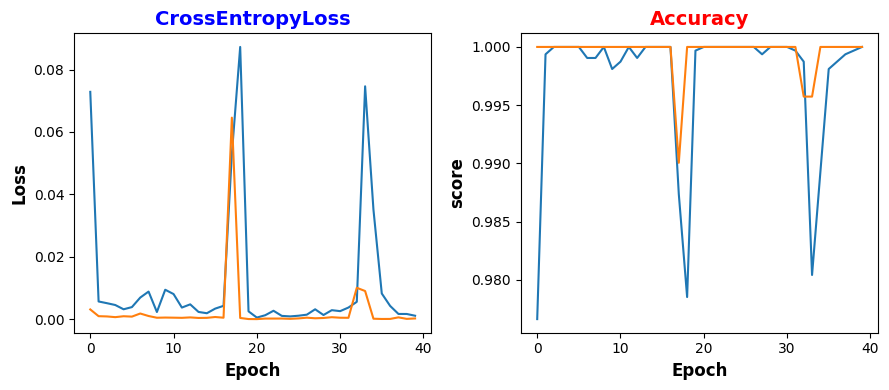

In [50]:
loss_and_metric_plot(RESULTS)

# **4. Evaluation Metrics**

In [51]:
def predictions(test_dataloader:torch.utils.data.DataLoader, best_model:str):
    
    checkpoint = torch.load(best_model)
    
    loaded_model = resnet50()
    
    loaded_model.fc = nn.Linear(in_features = 2048,  out_features = output_shape)

    loaded_model.load_state_dict(checkpoint)
    
    loaded_model.to(device = DEVICE)
    
    loaded_model.eval()
    
    y_pred_test = []
    
    with torch.inference_mode():
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y_pred_logit = loaded_model(X)
            y_pred_prob = y_pred_logit.softmax(dim = 1)
            y_pred_class = y_pred_prob.argmax(dim = 1)
            y_pred_test.append(y_pred_class.detach().cpu())
            
    y_pred_test = torch.cat(y_pred_test)
    
    return y_pred_test

In [52]:
# We create our Dataset and DataLoader for our test set.
test_dataset = CustomImageDataset(data_test,auto_transforms, label2id)
test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

In [53]:
# We make the predictions.
y_pred_test = predictions(test_dataloader, "/kaggle/working/best_model.pth")

  0%|          | 0/22 [00:00<?, ?it/s]

- **Accuracy**

In [54]:
test_accuracy = accuracy_score(data_test['Label'].map(label2id), y_pred_test.numpy())

print(f"Accuracy Test = {test_accuracy:.4f}")

Accuracy Test = 1.0000


- **Confusion Matrix**

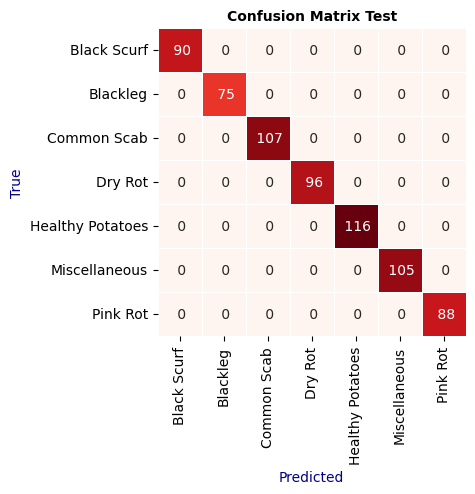

In [55]:
cf_mx_test = confusion_matrix(data_test['Label'].map(label2id), y_pred_test.numpy())

fig,ax = plt.subplots(figsize = (9,4))
sns.heatmap(cf_mx_test, cmap = 'Reds', fmt = ' ', annot = True, cbar = False, square = True, linewidths = 0.4,
            xticklabels = CLASSES, yticklabels = CLASSES, ax = ax)
ax.set_ylabel("True", color = "darkblue")
ax.set_xlabel("Predicted", color = "darkblue")
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "black")

fig.show()